Here I will describe a simple learning rules for online (real-time) inference of infection rates inspired by the work of [Bettencourt et al.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185). The idea is that a standard SIR model can be redefined as a stochastic process describing the evolution of daily cases, where the expectations are proportional to the infection rate. 

The generative model contains two components the likelihood defined as a poisson distribution 

$$ p(k_t|k_{t-1}, x_t) \propto \frac{\lambda_t^{k_t}}{k_t!}, \qquad \lambda_t = k_{t-1}e^{x_t}.$$

In the above equation $k_t$ and $k_{t-1}$ denote the observed number of daily cases on day $t$ and $t-1$. The 
random variable $x_t$ expresses the infection rate. For example, if $x_t > 0$ one expects growing number of daily counts (corresponding to $g(t)>1$), and if $x_t < 0$ one expects decreasing number of daily counts ($g(t) < 1$). 

The simplest case is to assume that $x_t$ follows a random walk, hence

$$x_t = x_{t-1} + \sigma_x \epsilon_t.$$

Alternatively, one can assume that $x_t$ follows more elaborate dynamics such as

\begin{equation}
    \begin{split}
        a_t & = a_{t-1} + \sigma_a \epsilon^a_t \\
        x_t & = a_{t-1} + x_{t-1} + \sigma_x \epsilon^x_t
    \end{split}
\end{equation}

where now the random variable $a_t$ expresses the changes in the infection rate. Positive $a_t$ corresponds to expectation that the $x_t$ will increase and negative $a_t$ corresponds to expectation that the $x_t$ will deacrease.

Let us first consider the simpler case when $x_t$ follows random walk. The Bayesian belief updating can be expressed as 

$$ p(x_t|k_{0}, \ldots, k_t) \propto p(k_t|k_{t-1}, x_t) p(x_t|k_0, \ldots, k_{t-1})$$

which states that the beliefs about the infection rate $x_t$ on day $t$ are porportional to the evidence obtained from observing $k_t$ daily cases and our prior expectations about infection rate $p(x_t|k_0, \ldots, k_{t-1})$. To express belief updating as a learnign rule we will use variational inference and an assumption that both posterior and prior over $x_t$ can be expressess as a normal distribution. Hence, 

$$ p(x_t|k_{0}, \ldots, k_t) = \mathcal{N}(x_t; \mu_t, \sigma_t)$$

and

$$ p(x_t|k_{0}, \ldots, k_{t-1}) = \mathcal{N}(x_t; \mu_{t-1}, \sigma_{t-1} + \sigma_x)$$

The last definition of prior over $x_t$ expresses our expectation that $x_t$ follows a random walk, and that 
prior on day $t$ is a funcitonal of the posterior on the previous day, that is

$$ p(x_t|k_{0}, \ldots, k_{t-1}) = \int d_{x_{t-1}} p(x_t|x_{t-1}) p(x_{t-1}|k_0, \ldots, k_{t-1})$$

Without going into details on the derivation steps, updating posterior expectation $\mu_t$ and uncertainty $\rho_t$ corresponds to the following update eqautions

\begin{equation}
    \begin{split}
        \mu_t & = \mu_{t-1} + \sigma_t \cdot(k_t - k_{t-1}\cdot e^{\mu_{t-1}}) \\
        \frac{1}{\sigma_t} & = \frac{1}{\sigma_{t-1} + \sigma_x} +  k_{t-1}e^{\mu_{t-1}} 
    \end{split}
\end{equation}

In other words, if the difference between expected $k_{t-1}\cdot e^{\mu_{t-1}}$ and observed cases $k_t$ is larger than zero, one will increse the expectation about the infection rate (probability of getting infected) and if the difference is smaller than zero one will deacrease the expectation. Importantly, the change in expectations about the infection probability is proportional to the uncertainty $\sigma_t$.

Let's assume that someone is following daily counts from new in Germany, and we use above equations to approximate this pearsons belief updating about the probability of getting infected. The time evolution of daily cases in germany looks as follows

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

df_global = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_germany = df_global.loc[df_global['Country/Region'] == "Germany"]
total = df_germany.set_index('Province/State').loc[np.nan].values[8:]
daily = np.diff(np.concatenate([np.zeros(1), total]))

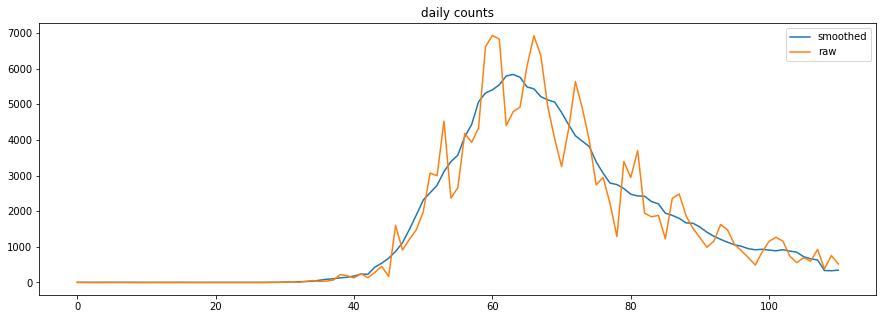

In [106]:
total_smooth = df_germany.set_index('Province/State').loc[np.nan].iloc[8:].rolling(window=7, min_periods=1, center=True).mean().values
daily_smooth = np.diff(np.concatenate([np.zeros(1), total_smooth]))

plt.plot(daily_smooth)
plt.plot(daily)
plt.legend(['smoothed', 'raw']);
plt.title('daily counts');

Text(0.5, 1.0, 'estimation from raw data')

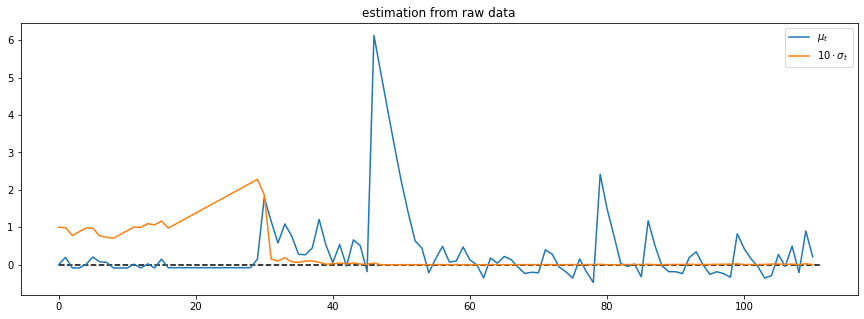

In [97]:
sigma_x = .01
mu = [0.]
sigma = [.1]
for k in range(1, len(daily)):
    pred = daily[k-1] * np.exp(mu[-1])
    pi = 1/(sigma[-1] + sigma_x) + pred
    sigma.append(1/pi)
    mu.append(mu[-1] + sigma[-1] * (daily[k] - pred))
    
plt.plot(np.array(mu), label=r'$\mu_t$')
plt.plot(10 * np.array(sigma), label=r'$10 \cdot \sigma_t$')
plt.hlines(0, 0, len(daily), 'k', linestyle='--');
plt.legend();
plt.title('estimation from raw data')

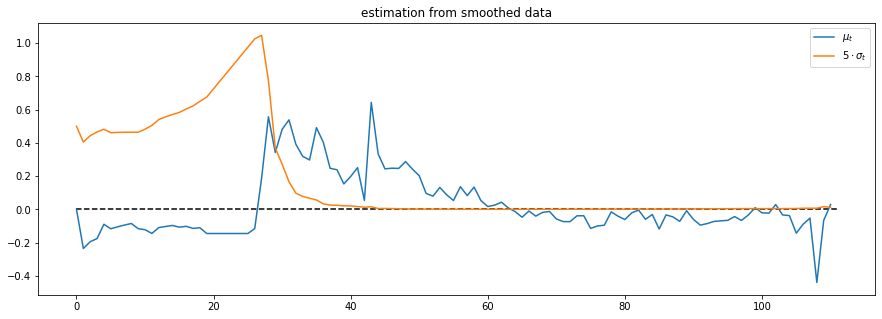

In [98]:
sigma_x = .01
mu = [0.]
sigma = [.1]
for k in range(1, len(daily_smooth)):
    pred = daily_smooth[k-1] * np.exp(mu[-1])
    pi = 1/(sigma[-1] + sigma_x) + pred
    sigma.append(1/pi)
    mu.append(mu[-1] + sigma[-1] * (daily_smooth[k] - pred))
    
plt.plot(np.array(mu), label=r'$\mu_t$')
plt.plot(5 * np.array(sigma), label=r'$5 \cdot \sigma_t$')
plt.hlines(0, 0, len(daily), 'k', linestyle='--');
plt.legend();
plt.title('estimation from smoothed data');

We can use the similar assumptions to estimate the acceleration of the infection rate $a_t$. Assuming that 
joint beliefs about $a_t$ and $x_t$ can be expresse as a multivariate normal distribution 

$$ p(a_t, x_t|k_0, \ldots, k_t) = \mathcal{N}_2\left(\vec{\mu}_t, \Sigma_t\right).$$

The extended model results in the following Bayes relation 

$$ p(a_t, x_t| k_0, \ldots, k_t) \propto p(k_t|x_t, k_{t-1}) p(x_t, a_t|k_0, \ldots, k_{t-1})$$

the approximate update equations for expectation $\mu_t$ and covariance $\Sigma_t$ become

\begin{equation}
    \begin{split}
        \mu^x_t & = \mu^x_{t-1} + \mu^a_{t-1} + \sigma^{x, x}_t \cdot(k_t - k_{t-1}\cdot e^{\mu^x_{t-1} + \mu^a_{t-1} }) \\
        \mu^a_t & = \mu^a_{t-1} + \sigma^{a, x}_t \cdot (k_t - k_{t-1}\cdot e^{\mu^x_{t-1} + \mu^a_{t-1} }) \\
        \Sigma_t^{-1} & = [F \Sigma_{t-1} F^T + Q]^{-1} + S_t
    \end{split}
\end{equation}

where $F = \begin{pmatrix} 1 & 0\\ 1 & 1 \end{pmatrix}$, $Q = \begin{pmatrix} \sigma_a & 0\\ 0 & \sigma_x \end{pmatrix}$, $S_t = \begin{pmatrix} 0 & 0\\ 0 & k_{t-1}e^{\mu_{t-1}^a + \mu_{t-1}^x} \end{pmatrix}$, and $\Sigma_t = \begin{pmatrix} \sigma^{a, a}_t & \sigma^{a,x} \\ \sigma^{a,x}  & \sigma^{x,x} \end{pmatrix}$

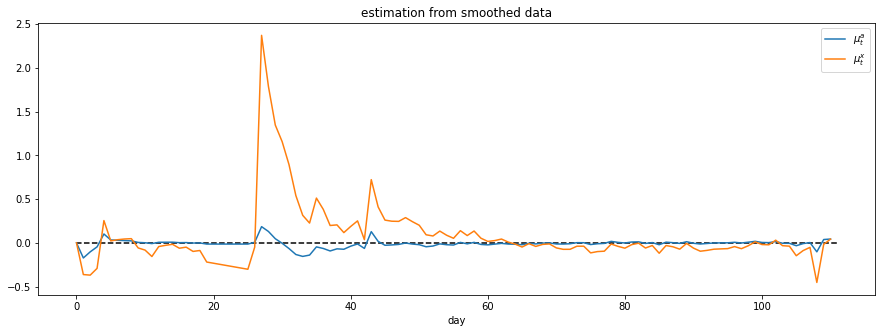

In [101]:
sigma_a = 0.001
sigma_x = 0.01

F = np.array([[1., 0.],[1., 1.]])
Q = np.diag([sigma_a, sigma_x])
S = np.array([[0., 0.],[0., 1.]])

mu = [np.zeros(2)]
Sigma = [np.diag([.1, .1])]

for k in range(1, len(daily_smooth)):
    mu_pred = np.dot(F, mu[-1])
    pred = daily_smooth[k-1] * np.exp(mu_pred[-1])
    delta = (daily_smooth[k] - pred)
    
    pi = np.linalg.pinv(np.matmul(np.matmul(F, Sigma[-1]), F.T) + Q) + pred * S
    Sigma.append(np.linalg.pinv(pi))
    
    mu.append(mu_pred + Sigma[-1][[0, 1], [1, 1]] * delta)
    
plt.plot(np.array(mu))
plt.legend([r'$\mu^a_t$', r'$\mu^x_t$'])
plt.hlines(0, 0, len(daily), 'k', linestyle='--');
plt.xlabel('day');
plt.title('estimation from smoothed data');